# ESM2 Embeddings Extraction and Antimicrobial Peptide (AMP) Classification

## Overview
This notebook demonstrates the process of:
1. Extracting and saving sequence embeddings from protein sequences using ESM2 models.
2. Train an SVM classifier to perform AMP classification (AMP vs non-AMP ).
3. Evaluate SVM performance on an independent test set and calculate important metrics.




In [ ]:
# Install dependencies
!pip install biopython numpy pandas torch tqdm scikit-learn seaborn matplotlib

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
from Bio import SeqIO
import torch
import gc
import os
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Helper Functions for Data Loading and Preparation

In [3]:
# Function to load sequences from FASTA files
def load_fasta(file_path):
    """
    Load sequences from a FASTA file and return them in a DataFrame.

    Args:
        file_path (str): Path to the FASTA file.

    Returns:
        pd.DataFrame: DataFrame containing 'seq_id' and 'sequence'.
    """
    with open(os.path.abspath(file_path)) as fasta_file:
        seq_ids, sequences = [], []
        for seq_record in SeqIO.parse(fasta_file, "fasta"):
            sequences.append(str(seq_record.seq))
            seq_ids.append(seq_record.id)
    data = pd.DataFrame({"seq_id": seq_ids, "sequence": sequences})
    data.drop_duplicates(inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data


In [4]:
def prepare_dataset(amp_fasta, non_amp_fasta):
    """
    Combine AMP and non-AMP sequences from FASTA files into a single dataset with sequence ids.

    Args:
        amp_fasta (str): Path to the FASTA file containing AMP sequences.
        non_amp_fasta (str): Path to the FASTA file containing non-AMP sequences.

    Returns:
        tuple:
            - data (list of tuples): Each tuple contains (seq_id, sequence).
            - labels (list of int): Binary labels (1 for AMP, 0 for non-AMP).

    Example:
        >>> data, labels = prepare_dataset("amp.fasta", "non_amp.fasta")
    """
    amp_data = load_fasta(amp_fasta)
    non_amp_data = load_fasta(non_amp_fasta)
    data = list(zip(amp_data["seq_id"], amp_data["sequence"])) + \
           list(zip(non_amp_data["seq_id"], non_amp_data["sequence"]))
    labels = [1] * len(amp_data) + [0] * len(non_amp_data)
    return data, labels


### Data Preparation
Loading and processing training and test datasets.


In [5]:
# File paths for training and test data
train_amp_fasta = "/path/to/your/folder/DRAMP_pretrain_train_positive.fasta"
train_non_amp_fasta = "/path/to/your/folder/DRAMP_pretrain_train_negative.fasta"
test_amp_fasta = "/path/to/your/folder/DRAMP_AMP.fasta"
test_non_amp_fasta = "/path/to/your/folder/DRAMP_nonAMP.fasta"

In [6]:
# Load datasets

# Train data
train_amp_data = load_fasta(train_amp_fasta)
train_non_amp_data = load_fasta(train_non_amp_fasta)

# Test data
test_amp_data = load_fasta(test_amp_fasta)
test_non_amp_data = load_fasta(test_non_amp_fasta)

# Prepare combined datasets
train_data, train_labels = prepare_dataset(train_amp_fasta, train_non_amp_fasta)
test_data, test_labels = prepare_dataset(test_amp_fasta, test_non_amp_fasta)

### ESM-2 Model Selection and Loading
Select model and provide the shorthand to load_esm2_model function to load it.

In [7]:
#@title ESM2 Model Versions Table

from IPython.core.display import HTML

html_table = """
<style>
    table {
        font-family: Arial, sans-serif;
        border-collapse: collapse;
        width: 80%;
        margin: auto;
        font-size: 16px;
    }
    th, td {
        border: 1px solid #dddddd;
        text-align: center;
        padding: 8px;
    }
    th {
        background-color: #f2f2f2;
        color: #333;
    }
    tr:nth-child(even) {
        background-color: #f9f9f9;
    }
    tr:hover {
        background-color: #f1f1f1;
    }
</style>
<table>
    <thead>
        <tr>
            <th>ESM-2 Model Version (Shorthand)</th>
            <th># Layers</th>
            <th># Params</th>
            <th>Embedding Dim</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>esm2_t48_15B_UR50D (t48)</td>
            <td>48</td>
            <td>15B</td>
            <td>5120</td>
        </tr>
        <tr>
            <td>esm2_t36_3B_UR50D (t36)</td>
            <td>36</td>
            <td>3B</td>
            <td>2560</td>
        </tr>
        <tr>
            <td>esm2_t33_650M_UR50D (t33)</td>
            <td>33</td>
            <td>650M</td>
            <td>1280</td>
        </tr>
        <tr>
            <td>esm2_t30_150M_UR50D (t30)</td>
            <td>30</td>
            <td>150M</td>
            <td>640</td>
        </tr>
        <tr>
            <td>esm2_t12_35M_UR50D (t12)</td>
            <td>12</td>
            <td>35M</td>
            <td>480</td>
        </tr>
        <tr>
            <td>esm2_t6_8M_UR50D (t6)</td>
            <td>6</td>
            <td>8M</td>
            <td>320</td>
        </tr>
    </tbody>
</table>
"""

display(HTML(html_table))




ESM-2 Model Version (Shorthand),# Layers,# Params,Embedding Dim
esm2_t48_15B_UR50D (t48),48,15B,5120
esm2_t36_3B_UR50D (t36),36,3B,2560
esm2_t33_650M_UR50D (t33),33,650M,1280
esm2_t30_150M_UR50D (t30),30,150M,640
esm2_t12_35M_UR50D (t12),12,35M,480
esm2_t6_8M_UR50D (t6),6,8M,320


In [8]:
def load_esm2_model(shorthand):
    """
    Load a pretrained ESM-2 model based on its shorthand identifier.

    Args:
        shorthand (str): Model shorthand (e.g., 't12', 't33').

    Returns:
        model: Loaded ESM-2 model.
        alphabet: Alphabet object from the ESM-2 model.
        layer_num (int): Number of layers in the selected model.
    """
    # Define model versions
    model_versions = {
        "t48": ("esm2_t48_15B_UR50D", 48),
        "t36": ("esm2_t36_3B_UR50D", 36),
        "t33": ("esm2_t33_650M_UR50D", 33),
        "t30": ("esm2_t30_150M_UR50D", 30),
        "t12": ("esm2_t12_35M_UR50D", 12),
        "t6": ("esm2_t6_8M_UR50D", 6),
    }

    # Load model
    if shorthand not in model_versions:
        raise ValueError(f"Invalid model shorthand '{shorthand}'.")

    model_name, layer_num = model_versions[shorthand]
    model, alphabet = torch.hub.load("facebookresearch/esm:main", model_name)
    batch_converter = alphabet.get_batch_converter()

    return model, alphabet, layer_num, batch_converter

# Define and load model
shorthand = "t12"  # Choose model shorthand
model, alphabet, layer_num, batch_converter = load_esm2_model(shorthand)

Downloading: "https://github.com/facebookresearch/esm/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t12_35M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t12_35M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t12_35M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t12_35M_UR50D-contact-regression.pt


### Embedding Extraction
This section extracts sequence embeddings using the ESM-2 model. Two types of embeddings are generated:
1. **Sequence Representations**: Averaged representations of all tokens in the sequence.
2. **CLS Token Representations**: Representations of the first token in the sequence.


In [9]:
def extract_sequence_representations(
    data,
    batch_converter,
    model,
    device,
    alphabet,
    last_layer_num,
    batch_size=8
):
    """
    Extracts sequence embeddings using a pre-trained ESM2 model.

    Args:
        data (list): List of tuples containing (label, sequence).
        batch_converter (callable): Converts batch data to input tensors for the model.
        model (torch.nn.Module): Pre-trained ESM-2 model.
        device (torch.device): Device to run the model on ('cuda' or 'cpu').
        alphabet: Alphabet object used by the model.
        last_layer_num (int): Layer number to extract representations from.
        batch_size (int, optional): Batch size for processing sequences. Default is 8.

    Returns:
        list: Per-sequence averaged embeddings.
        list: CLS token embeddings.
    """
    # Initialize storage for embeddings
    sequence_representations = []
    cls_token_representations = []

    # Move the model to the appropriate device
    model = model.to(device)
    model.eval()  # Set model to evaluation mode

    # Calculate total number of batches
    num_batches = (len(data) + batch_size - 1) // batch_size

    # Process sequences in batches
    with tqdm(total=num_batches, desc="Processing Batches", unit="batch") as pbar:
        for batch_start in range(0, len(data), batch_size):
            batch_data = data[batch_start:batch_start + batch_size]

            # Convert batch data to model input format
            try:
                batch_labels, batch_strs, batch_tokens = batch_converter(batch_data)
            except ValueError as e:
                print(f"Error processing batch: {e}")
                pbar.update(1)
                continue

            # Identify sequence lengths
            batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

            # Move tokens to the specified device
            batch_tokens = batch_tokens.to(device)

            # Forward pass to obtain embeddings
            with torch.no_grad():
                results = model(batch_tokens, repr_layers=[last_layer_num], return_contacts=False)
            token_representations = results["representations"][last_layer_num].to("cpu")

            # Extract embeddings for each sequence in the batch
            for idx, tokens_len in enumerate(batch_lens):
                # Average token embeddings, excluding special tokens
                sequence_representation = token_representations[idx, 1:tokens_len - 1].mean(0)
                sequence_representations.append(sequence_representation)

                # Extract the CLS token representation
                cls_token_representation = token_representations[idx, 0]
                cls_token_representations.append(cls_token_representation)

            pbar.update(1)  # Update progress bar

    return sequence_representations, cls_token_representations


In [10]:
# Define batch size
batch_size = 8

In [11]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# Extract embeddings for the training set

print("Extracting embeddings for training data...")

train_seq_representations, train_cls_representations = extract_sequence_representations(
    data=train_data,
    batch_converter=batch_converter,
    model=model,
    device=device,
    alphabet=alphabet,
    last_layer_num=layer_num,
    batch_size=batch_size,
)

# Save embeddings and labels
pd.DataFrame([rep.cpu().numpy() for rep in train_seq_representations]).to_csv(
    "train_sequence_embeddings.csv", index=False
)
pd.DataFrame([rep.cpu().numpy() for rep in train_cls_representations]).to_csv(
    "train_cls_embeddings.csv", index=False
)
pd.DataFrame({"label": train_labels}).to_csv("train_labels.csv", index=False)


print("Training embeddings saved.")

Extracting embeddings for training data...


Processing Batches: 100%|██████████| 951/951 [00:33<00:00, 28.51batch/s]


Training embeddings saved.


In [13]:
# Extract embeddings for the test set

print("Extracting embeddings for test data...")

test_seq_representations, test_cls_representations = extract_sequence_representations(
    data=test_data,
    batch_converter=batch_converter,
    model=model,
    device=device,
    alphabet=alphabet,
    last_layer_num=layer_num,
    batch_size=batch_size,
)

# Save embeddings and labels
pd.DataFrame([rep.cpu().numpy() for rep in test_seq_representations]).to_csv(
    "test_sequence_embeddings.csv", index=False
)
pd.DataFrame([rep.cpu().numpy() for rep in test_cls_representations]).to_csv(
    "test_cls_embeddings.csv", index=False
)
pd.DataFrame({"label": test_labels}).to_csv("test_labels.csv", index=False)


print("Test embeddings saved.")

Extracting embeddings for test data...


Processing Batches: 100%|██████████| 352/352 [00:11<00:00, 29.82batch/s]


Test embeddings saved.


### SVM Model Training and Evaluation
Train a Support Vector Machine (SVM) classifier using the extracted embeddings and evaluate its performance on the test dataset.


In [14]:
# Load saved embeddings and labels
train_embeddings = pd.read_csv("train_sequence_embeddings.csv").values
train_labels = pd.read_csv("train_labels.csv")["label"].values
test_embeddings = pd.read_csv("test_sequence_embeddings.csv").values
test_labels = pd.read_csv("test_labels.csv")["label"].values

# Initialize SVM
svm_model = SVC(kernel="rbf", C=10.0, gamma="scale", probability=True)

# Train the model
print("Training SVM...")
svm_model.fit(train_embeddings, train_labels)
print("Training complete!")


Training SVM...
Training complete!


In [15]:
# Make predictions
test_predictions = svm_model.predict(test_embeddings)
test_probabilities = svm_model.predict_proba(test_embeddings)[:, 1]  # Get probabilities for positive class

Metrics:
{'accuracy': 0.7468039772727273,
 'f1': 0.684931506849315,
 'mcc': 0.536738749956782,
 'precision': 0.9064327485380117,
 'recall': 0.5504261363636364,
 'roc_auc': 0.8168055006295196}


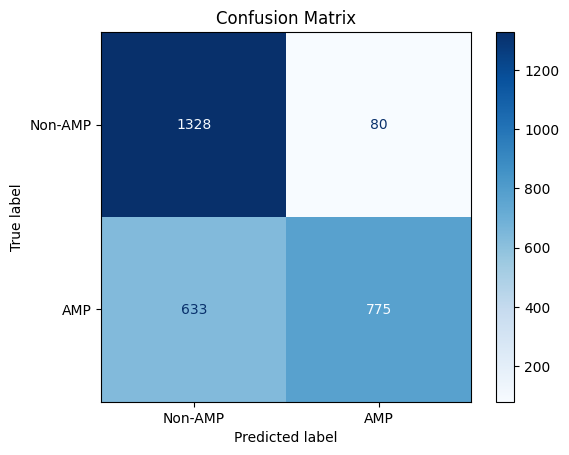

In [16]:
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Calculate metrics
accuracy = accuracy_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
mcc = matthews_corrcoef(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
roc_auc = roc_auc_score(test_labels, test_probabilities)

metrics = {
    "accuracy": accuracy,
    "f1": f1,
    "mcc": mcc,
    "precision": precision,
    "recall": recall,
    "roc_auc": roc_auc,
}

print("Metrics:")
from pprint import pprint
pprint(metrics)

# Confusion Matrix
cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-AMP", "AMP"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()